In [6]:
# Imports
import pymc3 as pm
import numpy.random as npr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
import seaborn as sns

# Set plotting style
# plt.style.use('fivethirtyeight')
sns.set_style('white')
sns.set_context('poster')

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Bayesian Data Analysis with PyMC3

Eric J. Ma, MIT Biological Engineering

PyCon 2017, Portland, OR

- Slides: https://github.com/ericmjl/bayesian-stats-talk
- Twitter: [@ericmjl](https://twitter.com/ericmjl)
- Website: [www.ericmjl.com](http://www.ericmjl.com)


# talk features

- **minimal field jargon:** let's focus on the mechanics of analysis, rather than the terminology. *e.g. won't explain A/B testing, spike & slab regression, conjugate distributions...*

- **pareto principle:** the basics will get you to 80% of what you'll need

 - **follow from home:** download the slides online and enjoy the talk! [GH: ericmjl/bayesian-stats-talk](github.com/ericmjl/bayesian_stats_talk)

## assumed knowledge

- familiarity with Python

- knowledge of basic stats terminology

![](./images/beliefs.jpg)

## the obligatory Bayes rule slide

![](https://qph.ec.quoracdn.net/main-qimg-4f187b486bb35176d82ad942dcb20fee-c)

## bayesian thinking

update beliefs having seen the evidence

## `pymc3`

![](https://github.com/pymc-devs/pymc3/blob/master/docs/pymc3_logo.jpg?raw=true)

- Bayesian statistical modelling in Python
- No need for specialized modelling syntax.
- Everything in Python!

# common statistical analysis problems

- **parameter estimation**: "is the true value equal to X?"

- **comparison between experimental groups**: "are the treatments different from the control?"

# problem type 1: parameter estimation

"is the true value equal to X?"

OR

"given the data, for the parameter of interest, what is the probability distribution over the possible values?"

# example 1: the obligatory coin toss problem

I threw my coin 30 times, and it came up as heads 11 times. Is it biased?

## parameters

We are most interested in the value `p`: the **probability of heads**.



## parameterized problem

"given the data, is it probable that the value of `p` equal to 0.5?"

## prior

- prior belief about parameter: $ p \sim Uniform(0, 1) $
- likelihood function: $ data \sim Bernoulli(p) $

![](./images/coin_model.jpg)

In [7]:
# Make the data needed for the problem.
from random import shuffle
total = 30
n_heads = 11
n_tails = total - n_heads
tosses = [1] * n_heads + [0] * n_tails
shuffle(tosses)

## data

In [8]:
print(tosses)

[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0]


In [9]:
def plot_coins():
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.bar(list(Counter(tosses).keys()), list(Counter(tosses).values()))
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['tails', 'heads'])
    ax.set_ylim(0, 20)
    ax.set_yticks(np.arange(0, 21, 5))
    return fig

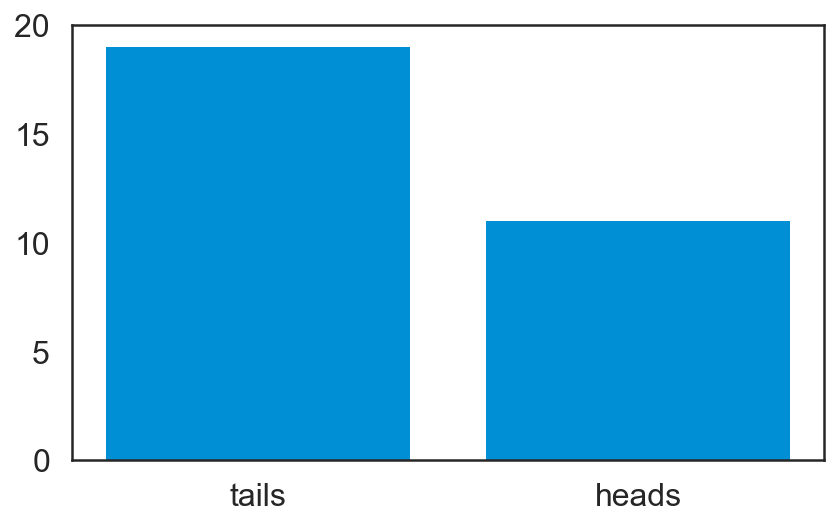

In [10]:
fig = plot_coins()
plt.show()

## code

In [11]:
# Context manager syntax. `coin_model` is **just** 
# a placeholder
with pm.Model() as coin_model: 
    # Specify prior using Uniform object.
    p_prior = pm.Uniform('p', 0, 1)  
    
    # Specify likelihood using Bernoulli object.
    like = pm.Bernoulli('likelihood', p=p_prior, 
                        observed=tosses)  
                        # "observed=data" is key
                        # for likelihood.

# Inference Button (TM)

In [12]:
with coin_model:
    # don't worry about this:
    step = pm.Metropolis()
    
    # focus on this, the Inference Button:
    coin_trace = pm.sample(2000, step=step)

100%|██████████| 2000/2000 [00:00<00:00, 6365.33it/s]


# results

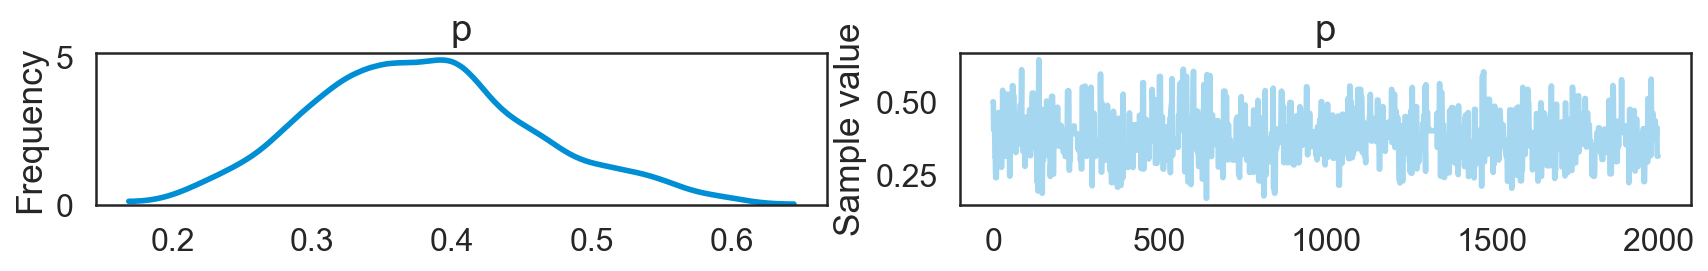

In [13]:
pm.traceplot(coin_trace)
plt.show()

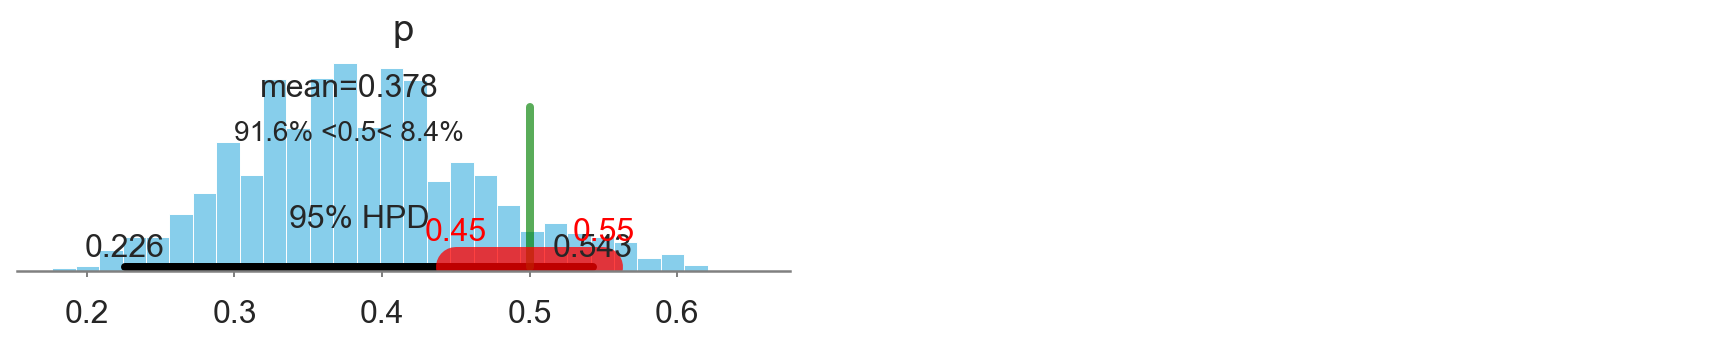

In [65]:
pm.plot_posterior(coin_trace[100:], color='#87ceeb', rope=[0.45, 0.55],
                       point_estimate='mean', ref_val=0.5)
plt.show()

- <font style="color:black; font-weight:bold">95% highest posterior density (HPD)</font> overlaps with the <font style="color:red; font-weight:bold">region of practical equivalence (ROPE)</font>. 
- Flip the coin a few more times.

# pattern

1. parameterize your problem using statistical distributions
1. justify your model structure
1. write model in PyMC3, hit the **Inference Button<sup>TM</sup>**
1. interpret based on posterior distributions

# example 2: the chemical activity problem

I have a newly developed molecule X; how good is X in stopping flu replication?  

<!-- mention verbally about the context: flu, replicating, need molecule to stop it -->

## experiment

test a range of concentrations of X, measure flu activity, compute **IC<sub>50</sub>**: the concentration of the X that causes the replication rate of the virus to be halved.

## data

![](./images/ic50_data.jpg)

## parameter

we are interested in the **IC<sub>50</sub>** of the molecule.

In [15]:
import numpy as np
chem_data = [(0.00080, 99),
(0.00800, 91),
(0.08000, 89),
(0.40000, 89),
(0.80000, 79),
(1.60000, 61),
(4.00000, 39),
(8.00000, 25),
(80.00000, 4)]

import pandas as pd

chem_df = pd.DataFrame(chem_data)
chem_df.columns = ['concentration', 'activity']
chem_df['concentration_log'] = chem_df['concentration'].apply(lambda x:np.log10(x))
# df.set_index('concentration', inplace=True)

## parameterized problem

given the data, what is the **IC<sub>50</sub>** value of the chemical, and the uncertainty surrounding it?

## prior

(a semi-good example that can be improved)

- measurement function from domain knowledge: $ m = \frac{\beta}{1 + e^{x - IC_{50}}} $
- prior belief about constant to be estimated: $ \beta \sim N(0, 100^2) $
- prior belief about parameter of interest: $ log(IC_{50}) \sim N(0, 100^2) $
- likelihood function: $ data \sim N(m, 1) $

![](./images/ic50_model.jpg)

## data

In [68]:
def plot_chemical_data():
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x=chem_df['concentration_log'], y=chem_df['activity'])
    ax.set_xlabel('log10(concentration (mM))')
    plt.hlines(y=50, xmin=-3, xmax=2, linestyles='--',)
    return fig

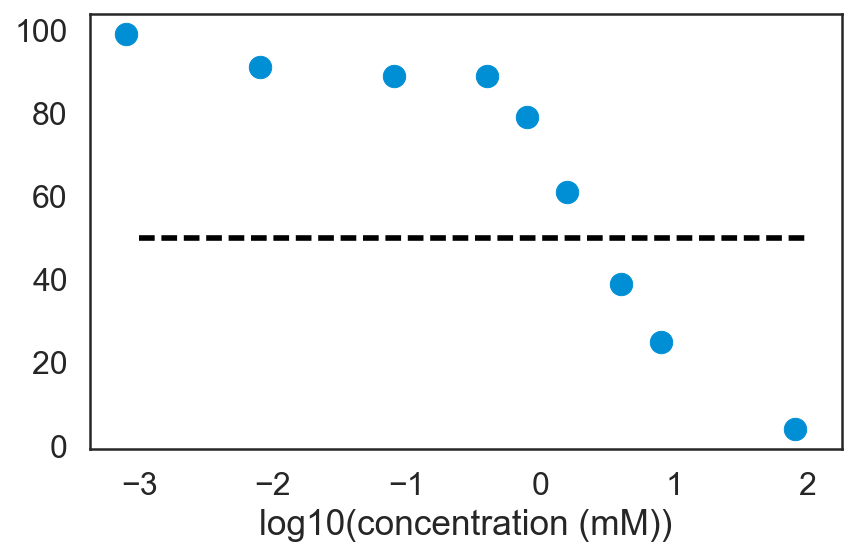

In [69]:
fig = plot_chemical_data()
plt.show()

## code

In [18]:
with pm.Model() as ic50_model:
    beta = pm.Normal('beta', mu=0, sd=100**2)
    ic50_log10 = pm.Normal('IC50_log10', sd=100**2)
    measurements = beta / (1 + np.exp(chem_df['concentration_log'].values - 
                                      ic50_log10))
    
    y_like = pm.Normal('y_like', mu=measurements, 
                       observed=chem_df['activity'])
    # transform back to non-log space.
    ic50 = pm.Deterministic('IC50', np.power(10, ic50_log10))

## Inference Button (TM)

In [19]:
with ic50_model:
    step = pm.Metropolis()
    ic50_trace = pm.sample(10000, step=step)

100%|██████████| 10000/10000 [00:01<00:00, 5748.74it/s]


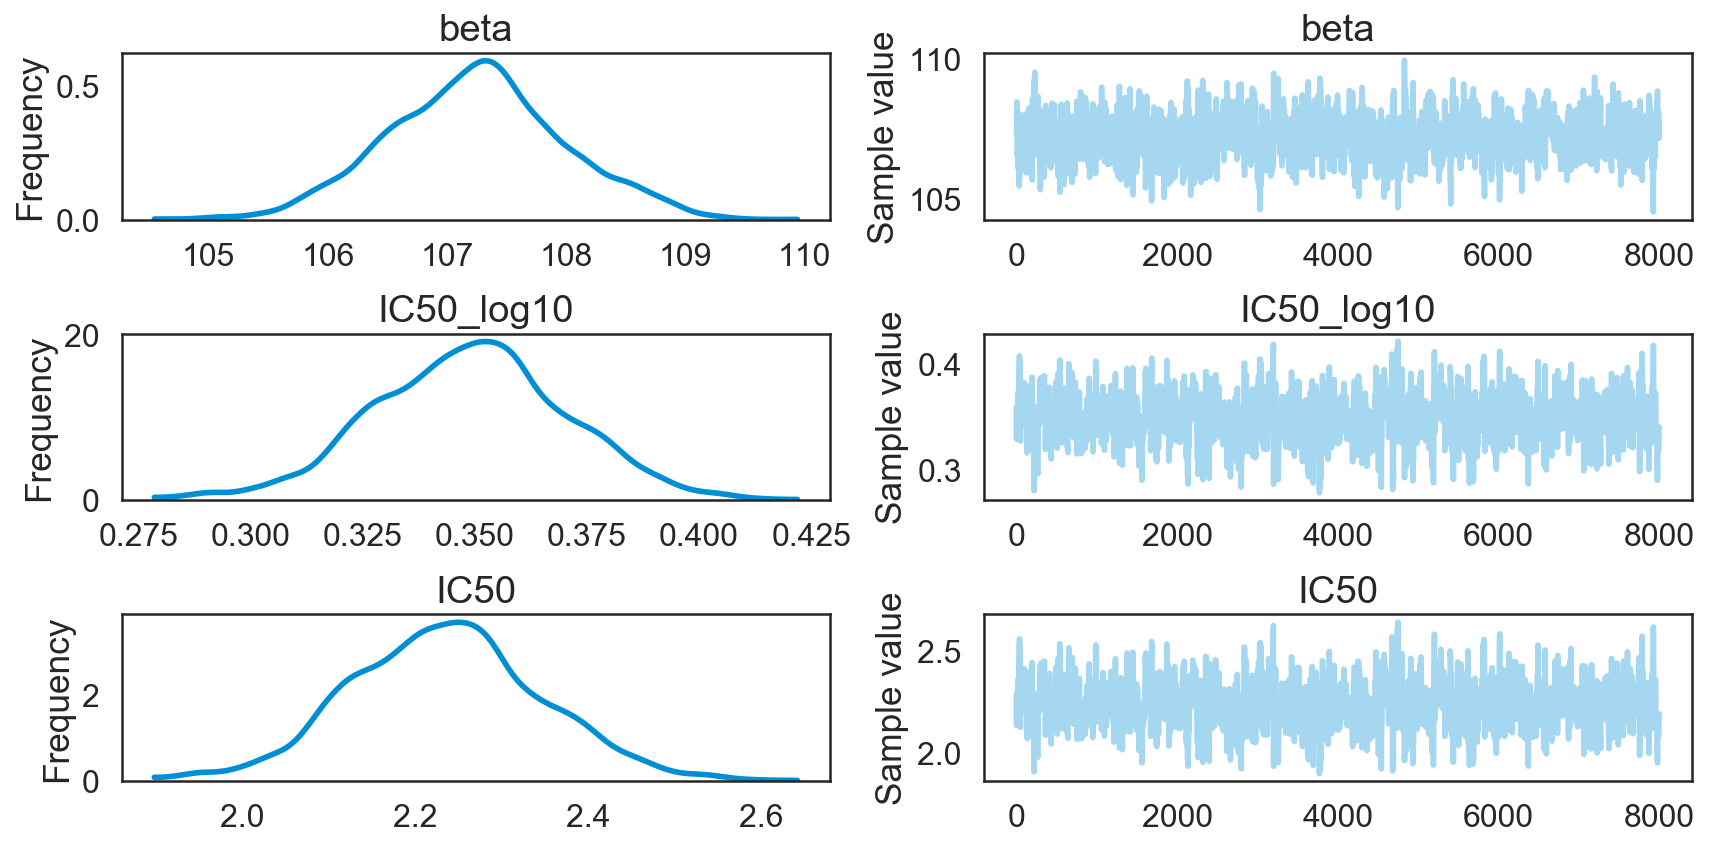

In [20]:
pm.traceplot(ic50_trace[2000:])  # live: sample from step 2000 onwards.
plt.show()

## results

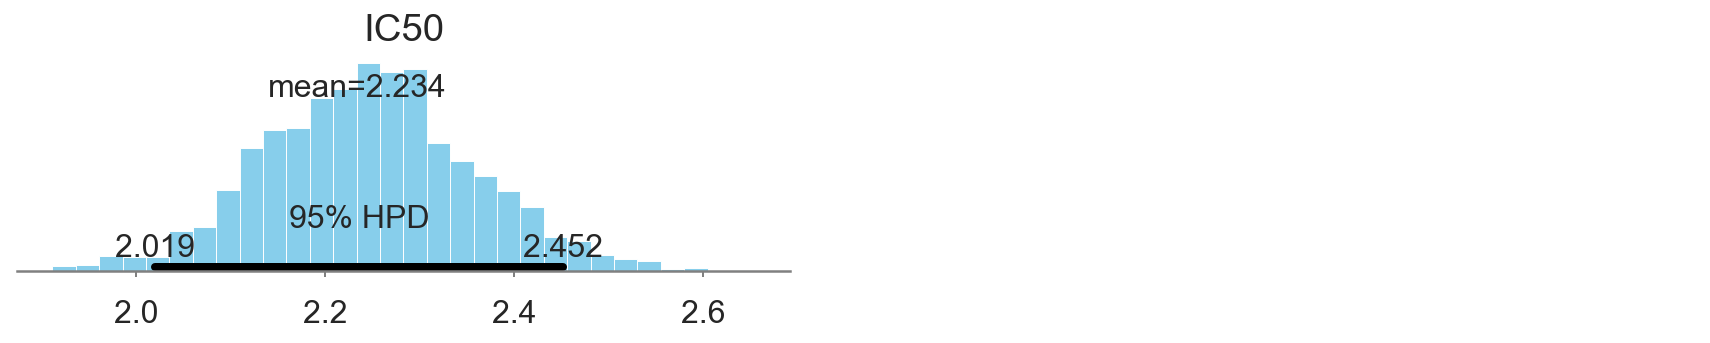

In [21]:
pm.plot_posterior(ic50_trace[2000:], varnames=['IC50'], 
                  color='#87ceeb', point_estimate='mean')
plt.show()

The IC<sub>50</sub> of the chemical is between approx. [2 mM, 2.4 mM] (95% HPD). It's kind of a bad chemical.

# problem type 2: comparison between treatment groups

"are my experimental treatments different from my controls?"

# example 1: the drug IQ problem

does a drug treatment affect IQ scores? 

(from Kruschke, 2013, example copied from PyMC3 documentation)

In [22]:
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

def ECDF(data):
    x = np.sort(data)
    y = np.cumsum(x) / np.sum(x)
    
    return x, y

def plot_drug():
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    x_drug, y_drug = ECDF(drug)
    ax.plot(x_drug, y_drug, label='drug, n={0}'.format(len(drug)))
    x_placebo, y_placebo = ECDF(placebo)
    ax.plot(x_placebo, y_placebo, label='placebo, n={0}'.format(len(placebo)))
    ax.legend()
    ax.set_xlabel('IQ Score')
    ax.set_ylabel('Cumulative Frequency')
    ax.hlines(0.5, ax.get_xlim()[0], ax.get_xlim()[1], linestyle='--')
    
    return fig

## experiment

- randomly assign participants to two treatment groups: 
    - `+drug` vs. `-drug`
- measure IQ score for each participant

## priors
- measured data are t-distributed: $ data \sim StudentsT(\mu, \sigma, \nu) $
- means are normally distributed: $ \mu \sim N(0, 100^2) $
- degrees of freedom are exponentially-distributed: $ \nu \sim Exp(30) $
- variance is positively-distributed: $ \sigma \sim HalfCauchy(100^2) $

![](./images/kruschke_model.jpg)

## data

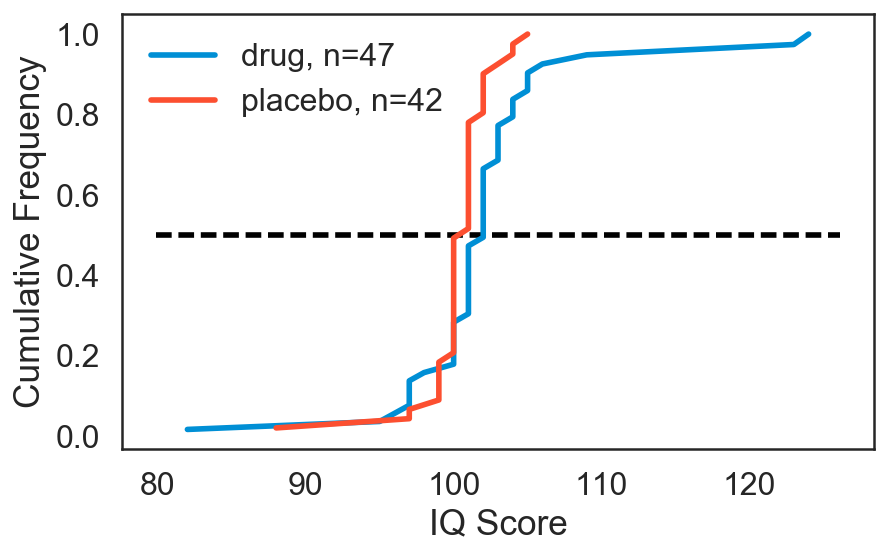

In [23]:
fig = plot_drug()
plt.show()

## code

In [24]:
y_vals = np.concatenate([drug, placebo])
labels = ['drug'] * len(drug) + ['placebo'] * len(placebo)

data = pd.DataFrame([y_vals, labels]).T
data.columns = ['IQ', 'treatment']

In [25]:
with pm.Model() as kruschke_model:
    # Focus on the use of Distribution Objects.
    # Linking Distribution Objects together is done by 
    # passing objects into other objects' parameters.
    mu_drug = pm.Normal('mu_drug', mu=0, sd=100**2)
    mu_placebo = pm.Normal('mu_placebo', mu=0, sd=100**2)
    sigma_drug = pm.HalfCauchy('sigma_drug', beta=100)
    sigma_placebo = pm.HalfCauchy('sigma_placebo', beta=100)
    nu = pm.Exponential('nu', lam=1/29) + 1
    
    drug_like = pm.StudentT('drug', nu=nu, mu=mu_drug, 
                            sd=sigma_drug, observed=drug)
    placebo_like = pm.StudentT('placebo', nu=nu, mu=mu_placebo, 
                               sd=sigma_placebo, observed=placebo)
    diff_means = pm.Deterministic('diff_means', mu_drug - mu_placebo)
    pooled_sd = pm.Deterministic('pooled_sd', 
                                 np.sqrt(np.power(sigma_drug, 2) + 
                                         np.power(sigma_placebo, 2) / 2))
    effect_size = pm.Deterministic('effect_size', 
                                   diff_means / pooled_sd)

## Inference Button (TM)

In [26]:
with kruschke_model:
    kruschke_trace = pm.sample(10000, step=pm.Metropolis())

100%|██████████| 10000/10000 [00:07<00:00, 1368.84it/s]


## results

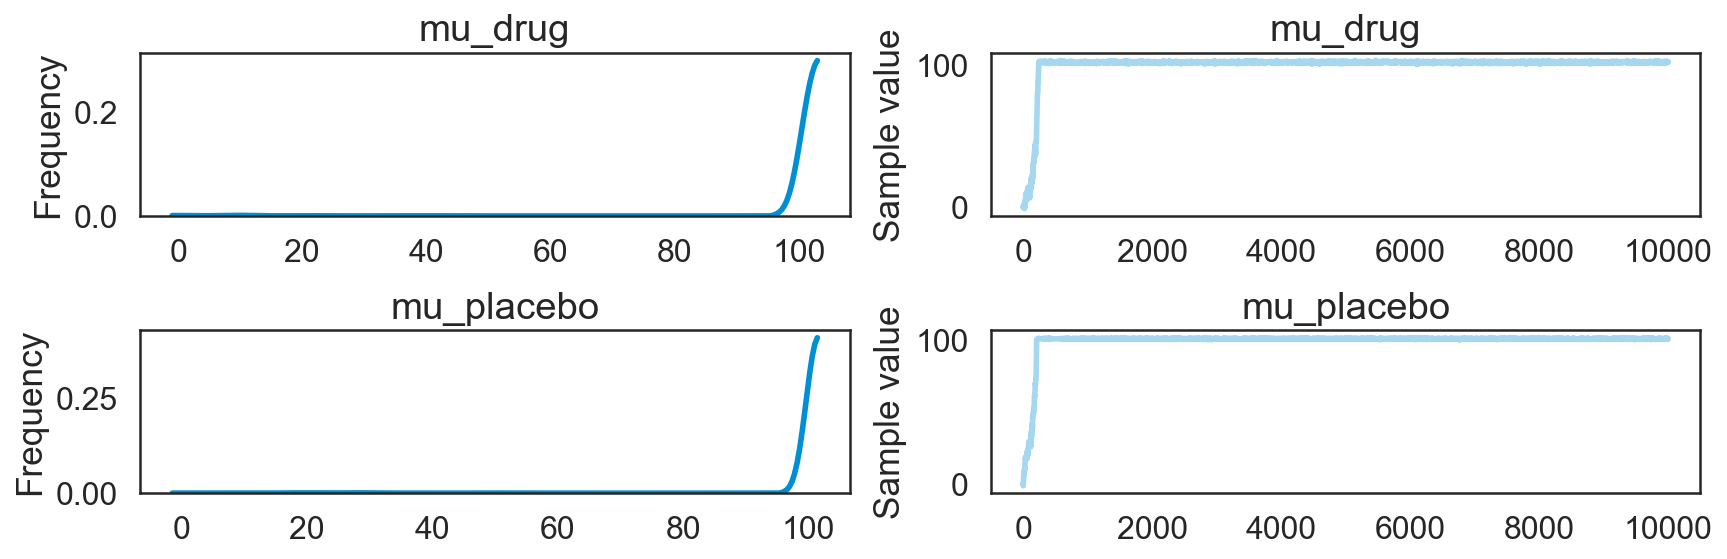

In [27]:
pm.traceplot(kruschke_trace, varnames=['mu_drug', 'mu_placebo'])
plt.show()

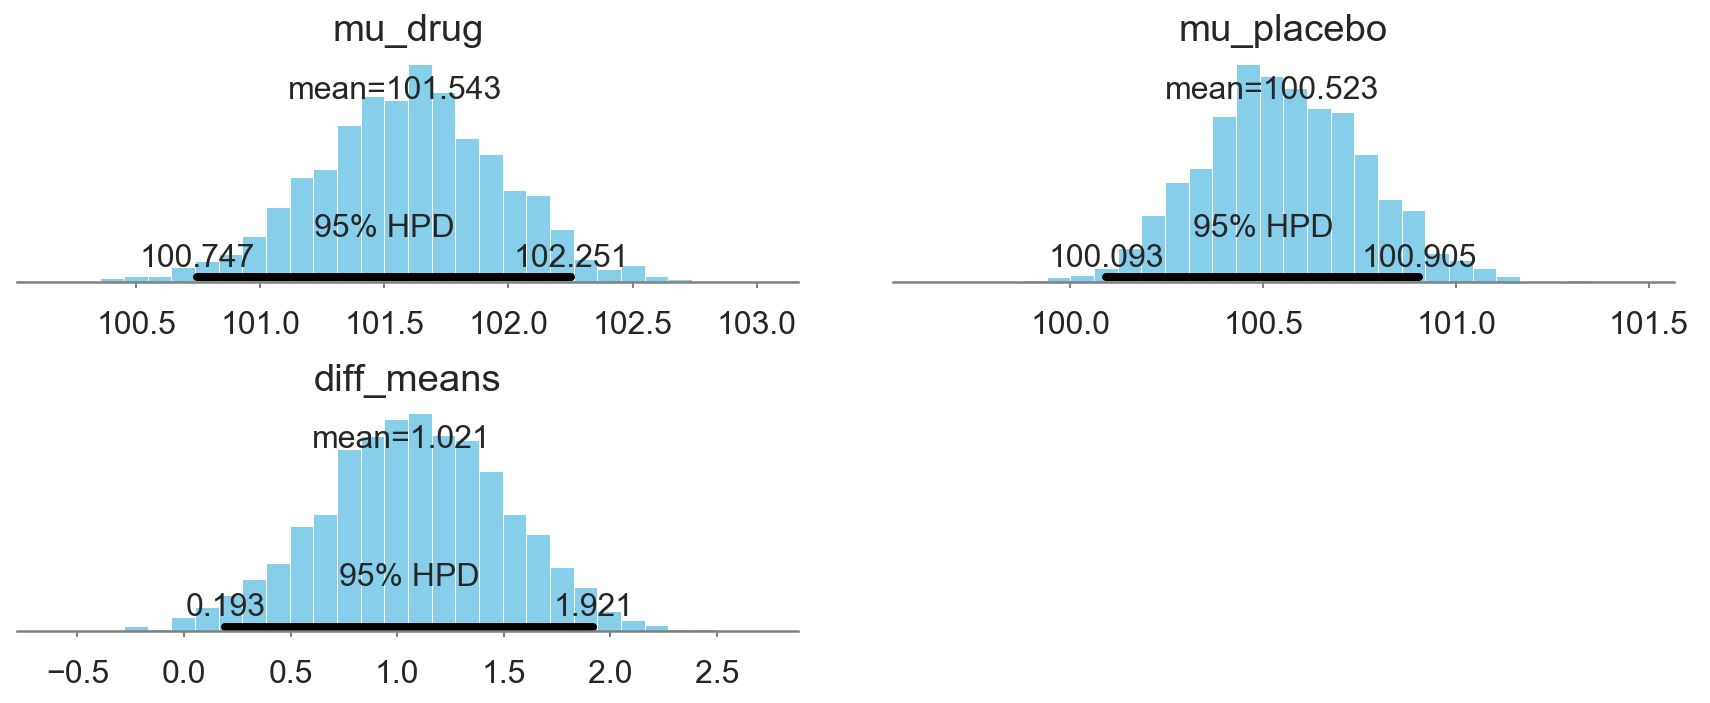

In [28]:
pm.plot_posterior(kruschke_trace[2000:], color='#87ceeb',
            varnames=['mu_drug', 'mu_placebo', 'diff_means'])
plt.show()

- Difference in mean IQ: [0, 2]

In [126]:
def get_forestplot_line(ax, kind):
    widths = {'median': 2.8, 'iqr': 2.0, 'hpd': 1.0}
    assert kind in widths.keys(), f'line kind must be one of {widths.keys()}'
    lines = []
    for child in ax.get_children():
        if isinstance(child, mpl.lines.Line2D) and np.allclose(child.get_lw(), widths[kind]):
            lines.append(child)
    return lines

def make_custom_forestplot():
    pm.forestplot(kruschke_trace[2000:], 
              varnames=['mu_drug', 'mu_placebo'])
    ax = plt.gca()
    
    for line in get_forestplot_line(ax, kind='median'):
        line.set_markersize(20)

    for line in get_forestplot_line(ax, kind='iqr'):
        line.set_linewidth(10)

    for line in get_forestplot_line(ax, kind='hpd'):
        line.set_linewidth(3)
        
    return ax

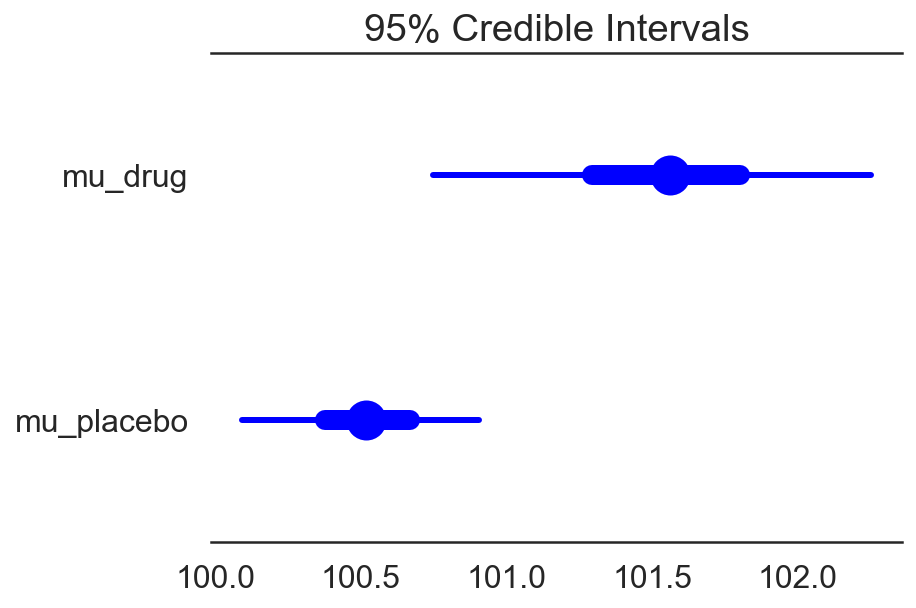

In [128]:
ax = make_custom_forestplot()
plt.show()

**Forest plot**: 95% HPD (thin line), IQR (thicker line), and median (dot) of the posterior distribution on the same axes, allowing us to directly compare the treatment and control.

In [30]:
def overlay_effect_size(ax):
    height = ax.get_ylim()[1] * 0.5
    ax.hlines(height, 0, 0.2, 'red', lw=5)
    ax.hlines(height, 0.2, 0.8, 'blue', lw=5)
    ax.hlines(height, 0.8, ax.get_xlim()[1], 'green', lw=5)

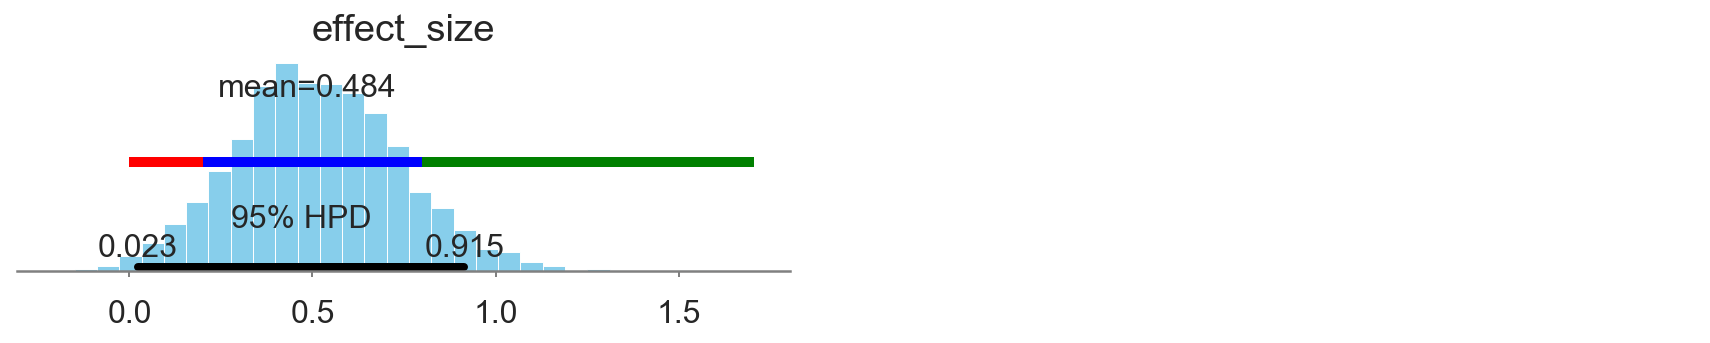

In [31]:
ax = pm.plot_posterior(kruschke_trace[2000:], 
                       varnames=['effect_size'],
                       color='#87ceeb')[0]
overlay_effect_size(ax)

- Effect size (Cohen's d, <font style="color:red;">none to small</font>, <font style="color:blue;">medium</font>, <font style="color:green;">large</font>) could be anywhere from essentially nothing to large (95% HPD [0.0, 0.9]). 
- Improvement in IQ is 0-2 points.
- The drug is very likely inconsequential.
- No evidence of **biological significance**.

# example 2: the phone sterilization problem

compared to two commonly-used treatments, do my "fancy methods" sterilize my phone better?

## the experiment design

- randomly assign phones to one of six groups: 4 "fancy" methods + 2 "control" methods.
- swab phone before and after treatment, grow bacteria
- **count** number of bacteria colonies formed, compare counts before and after

In [32]:
renamed_treatments = dict()
renamed_treatments['FBM_2'] = 'FM1'
renamed_treatments['bleachwipe'] = 'CTRL1'
renamed_treatments['ethanol'] = 'CTRL2'
renamed_treatments['kimwipe'] = 'FM2'
renamed_treatments['phonesoap'] = 'FM3'
renamed_treatments['quatricide'] = 'FM4'

# Reload the data one more time.
data = pd.read_csv('datasets/smartphone_sanitization_manuscript.csv', na_values=['#DIV/0!'])
del data['perc_reduction colonies']

# Exclude cellblaster data
data = data[data['treatment'] != 'CB30']
data = data[data['treatment'] != 'cellblaster']

# Rename treatments
data['treatment'] = data['treatment'].apply(lambda x: renamed_treatments[x])

# Sort the data according to the treatments.
treatment_order = ['FM1', 'FM2', 'FM3', 'FM4', 'CTRL1', 'CTRL2']
data['treatment'] = data['treatment'].astype('category')
data['treatment'].cat.set_categories(treatment_order, inplace=True)
data = data.sort_values(['treatment']).reset_index(drop=True)

# Encode the treatment index.
data['treatment_idx'] = data['treatment'].apply(lambda x: treatment_order.index(x))
data['perc_change_colonies'] = (data['colonies_post'] - data['colonies_pre']) / data['colonies_pre']

# # View the first 5 rows.
# data.head(5)

# # filter the data such that we have only PhoneSoap (PS-300) and Ethanol (ET)
# data_filtered = data[(data['treatment'] == 'PS-300') | (data['treatment'] == 'QA')]
# data_filtered = data_filtered[data_filtered['site'] == 'phone']
# data_filtered.sample(10)

## data

In [134]:
def plot_colonies_data():
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(2,1,1)
    sns.swarmplot(x='treatment', y='colonies_pre', data=data, ax=ax1)
    ax1.set_title('pre-treatment')
    ax1.set_xlabel('')
    ax1.set_ylabel('colonies')
    ax2 = fig.add_subplot(2,1,2)
    sns.swarmplot(x='treatment', y='colonies_post', data=data, ax=ax2)
    ax2.set_title('post-treatment')
    ax2.set_ylabel('colonies')
    ax2.set_ylim(ax1.get_ylim())
    plt.tight_layout()
    return fig

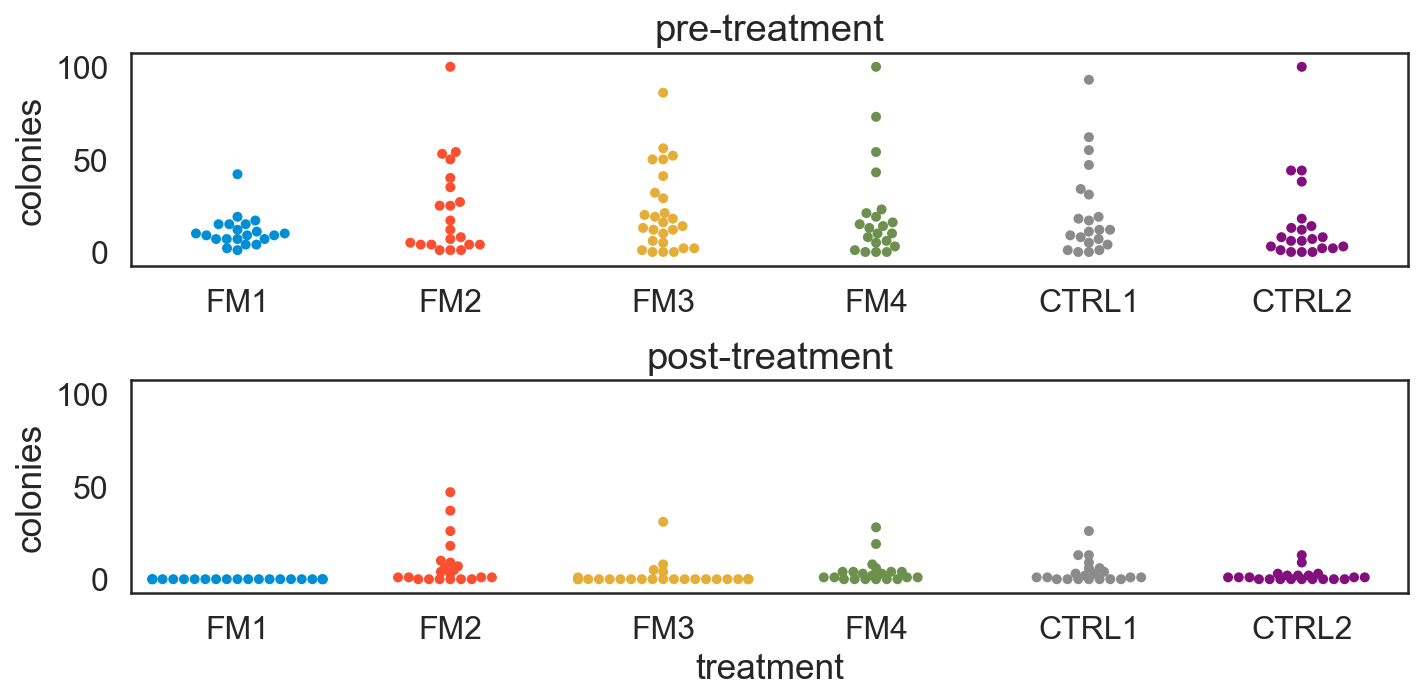

In [135]:
fig = plot_colonies_data()
plt.show()

## priors

Counts are **Poisson** distributed. Thus...

- Count likelihoods are Poisson distributed: $ data_{i}^{j} \sim Poisson(\mu_{i}^{j}), j \in [pre, post], i \in [1, 2, 3...] $
- Priors for Poisson parameters are discrete uniform distributed: $ \mu_{i}^{j} \sim DiscreteUniform(0, 10^{4}), j \in [pre, post], i \in [1, 2, 3...] $
- Sterilization efficacy is measured by percentage change, defined as: $ \frac{mu_{pre} - mu_{post}}{mu_{pre}} $

![](./images/bacteria_model.jpg)

## code

In [35]:
with pm.Model() as poisson_estimation:
    
    mu_pre = pm.DiscreteUniform('pre_mus', lower=0, upper=10000, 
                                shape=len(treatment_order))
    pre_mus = mu_pre[data['treatment_idx'].values]  # fancy indexing!!
    pre_counts = pm.Poisson('pre_counts', mu=pre_mus, 
                            observed=data['colonies_pre'])
    
    mu_post = pm.DiscreteUniform('post_mus', lower=0, upper=10000, 
                                 shape=len(treatment_order))
    post_mus = mu_post[data['treatment_idx'].values]  # fancy indexing!!
    post_counts = pm.Poisson('post_counts', mu=post_mus, 
                             observed=data['colonies_post'])

    perc_change = pm.Deterministic('perc_change', 
                                   100 * (mu_pre - mu_post) / mu_pre)

## Inference Button (TM)

In [36]:
with poisson_estimation:
    poisson_trace = pm.sample(20000)

Assigned Metropolis to pre_mus
Assigned Metropolis to post_mus
100%|██████████| 20000/20000 [00:06<00:00, 3239.51it/s]


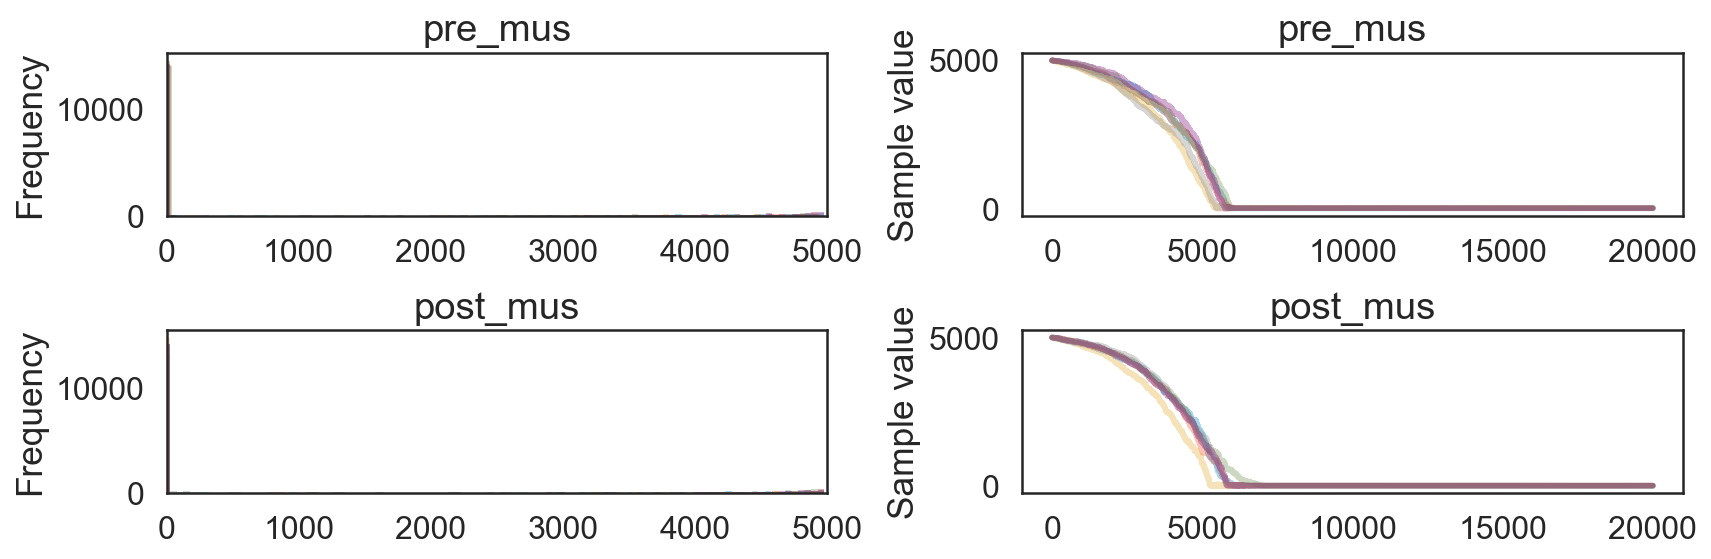

In [37]:
pm.traceplot(poisson_trace, varnames=['pre_mus', 'post_mus'])
plt.show()

## results

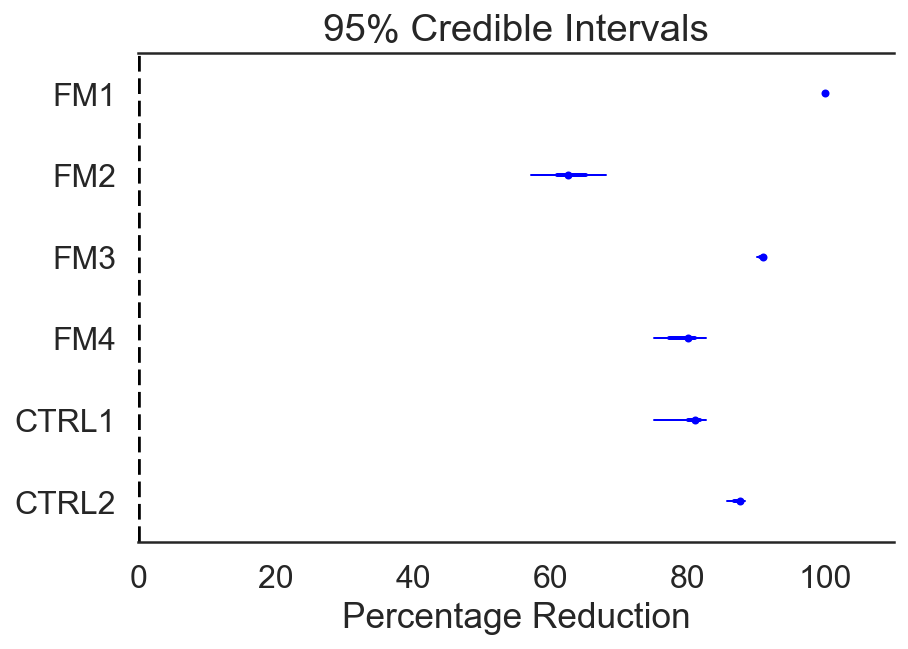

In [39]:
pm.forestplot(poisson_trace[10000:], varnames=['perc_change'], 
              ylabels=treatment_order, xrange=[0, 110])
plt.xlabel('Percentage Reduction')

Given the data, **Fancy Method 1** outperforms every other method, including controls.

No need for multiple hypothesis correction; posterior distributions summarize everything we know, given the data.

# bayesian estimation

- write a **descriptive** model for how the data were generated.
    - original bayes: do this **before** seeing your data.
    - empirical bayes: do this **after** seeing your data.
- estimate **posterior distributions** of model parameters of interest.
- **deterministically compute** posterior distributions of derived parameters.

# resources

- John K. Kruschke's [books][kruschke_books], [paper][kruschke_paper], and [video][kruschke_video].
- Statistical Re-thinking [book][mcelreath]
- Jake Vanderplas' [blog post][jakevdp_blog] on the differences between Frequentism and Bayesianism.
- PyMC3 [examples & documentation][pymc3]
- Andrew Gelman's [blog][gelman]
- Recommendations for prior distributions [wiki][priors]

[kruschke_books]: https://sites.google.com/site/doingbayesiandataanalysis/
[kruschke_paper]: http://www.indiana.edu/~kruschke/BEST/
[kruschke_video]: https://www.youtube.com/watch?v=fhw1j1Ru2i0&feature=youtu.be
[jakevdp_blog]: http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/
[pymc3]: https://pymc-devs.github.io/pymc3/examples.html
[mcelreath]: http://xcelab.net/rm/statistical-rethinking/
[gelman]: http://andrewgelman.com/
[priors]: https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations

# GO BAYES!

https://github.com/ericmjl/bayesian-stats-talk